In [1]:
import numpy as np
import pandas as pd
import os
import os.path as path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Input, SpatialDropout1D,Flatten, Dropout,GlobalMaxPooling1D,Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix,balanced_accuracy_score, make_scorer, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from google.colab import files

Using TensorFlow backend.


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [4]:
from google.colab import files
uploaded = files.upload()

Saving training_gospels.csv to training_gospels.csv


In [5]:
df = pd.read_csv("training_gospels.csv", delimiter=',', header=None,names=['id', 't','label'])

In [6]:
# Prepare predicted labels
df = df.iloc[1:]
Y = df.label
Y_series=pd.Series(Y,dtype='category')
Y = Y_series.cat.codes
y_prep = to_categorical(Y)
print(y_prep.shape)
print(Y_series)

(2400, 4)
1       0
2       0
3       0
4       0
5       0
       ..
2396    3
2397    3
2398    3
2399    3
2400    3
Name: label, Length: 2400, dtype: category
Categories (4, object): [0, 1, 2, 3]


In [7]:
# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.t)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
prep_data = tokenizer.texts_to_sequences(df.t)

In [8]:
prep_data = pad_sequences(prep_data, maxlen=200,padding="post")

In [9]:
print(len(prep_data))
print(len(Y))

2400
2400


In [10]:
# prepare train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(prep_data, y_prep, test_size=0.2, random_state=42)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
def get_model(embed,dropout,neurons):
    model = Sequential()
    model.add(Embedding(vocab_size, output_dim=embed, input_length=200))
    model.add(Dropout(dropout))
    model.add(Conv1D(neurons,5,activation='sigmoid'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(4, activation='softmax'))
    optimizer=Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

In [13]:
embedding1 = 128
embedding2 = 256
embedding3 = 512
dropout1 = 0.3
dropout2 = 0.5
dropout3 = 0.7
neuron1 = 32
neuron2 = 64
neuron3 = 128

In [14]:
model1 = get_model(embedding2, dropout2, neuron1)
model2 = get_model(embedding2, dropout2, neuron2)
model3 = get_model(embedding2, dropout2, neuron3)

In [15]:
history1 = model1.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history2 = model2.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history3 = model3.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
45/45 [==============================] - 1s 23ms/step - loss: 1.4436 - categorical_accuracy: 0.2486 - val_loss: 1.3884 - val_categorical_accuracy: 0.2771
Epoch 2/20
45/45 [==============================] - 1s 18ms/step - loss: 1.3818 - categorical_accuracy: 0.2972 - val_loss: 1.3806 - val_categorical_accuracy: 0.3229
Epoch 3/20
45/45 [==============================] - 1s 18ms/step - loss: 1.3645 - categorical_accuracy: 0.3667 - val_loss: 1.3712 - val_categorical_accuracy: 0.3521
Epoch 4/20
45/45 [==============================] - 1s 18ms/step - loss: 1.3386 - categorical_accuracy: 0.4549 - val_loss: 1.3594 - val_categorical_accuracy: 0.3771
Epoch 5/20
45/45 [==============================] - 1s 18ms/step - loss: 1.2841 - categorical_accuracy: 0.5528 - val_loss: 1.3366 - val_categorical_accuracy: 0.3458
Epoch 6/20
45/45 [==============================] - 1s 18ms/step - loss: 1.2080 - categorical_accuracy: 0.5882 - val_loss: 1.3163 - val_categorical_accuracy: 0.3688
Epoch 7/20

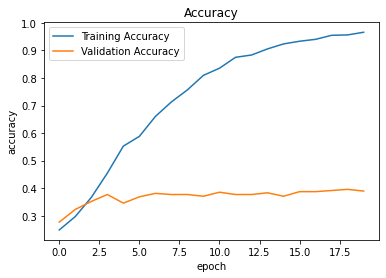

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

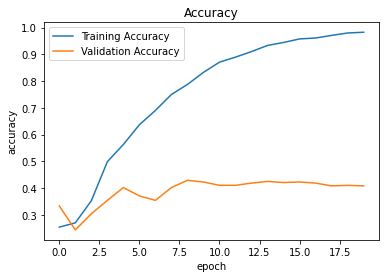

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

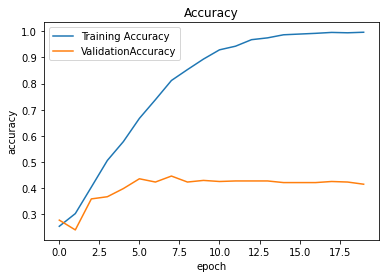

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m1acc.png', dpi=600)
plt.show()
files.download("m1acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m2acc.png', dpi=600)
plt.show()
files.download("m2acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m3acc.png', dpi=600)
plt.show()
files.download("m3acc.png") 

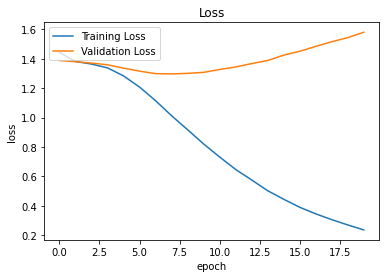

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

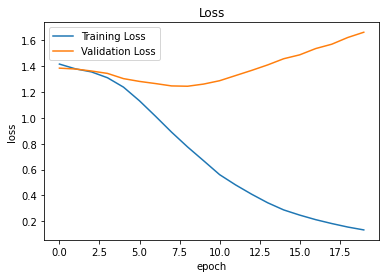

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

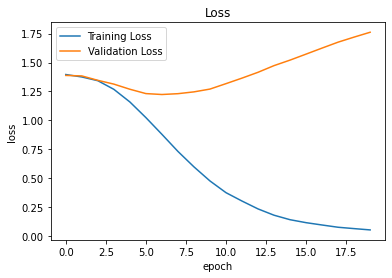

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m1loss.png', dpi=600)
plt.show()
files.download("m1loss.png") 


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m2loss.png', dpi=600)
plt.show()
files.download("m2loss.png") 


plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m3loss.png', dpi=600)
plt.show()
files.download("m3loss.png") 

In [18]:
loss1, accuracy1 = model1.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss1, accuracy1))

loss2, accuracy2 = model2.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss2, accuracy2))

loss3, accuracy3 = model3.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss3, accuracy3))

Loss:	1.4315718412399292
Accuracy:	0.4312500059604645
Loss:	1.5969107151031494
Accuracy:	0.42500001192092896
Loss:	1.6754149198532104
Accuracy:	0.4645833373069763


Next session

In [19]:
model4 = get_model(embedding1, dropout2, neuron1)
model5 = get_model(embedding2, dropout2, neuron1)
model6 = get_model(embedding3, dropout2, neuron1)

In [20]:
history4 = model4.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history5 = model5.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history6 = model6.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
45/45 [==============================] - 1s 15ms/step - loss: 1.5511 - categorical_accuracy: 0.2306 - val_loss: 1.3924 - val_categorical_accuracy: 0.2625
Epoch 2/20
45/45 [==============================] - 0s 11ms/step - loss: 1.3875 - categorical_accuracy: 0.2500 - val_loss: 1.3817 - val_categorical_accuracy: 0.2854
Epoch 3/20
45/45 [==============================] - 1s 11ms/step - loss: 1.3773 - categorical_accuracy: 0.3000 - val_loss: 1.3805 - val_categorical_accuracy: 0.2542
Epoch 4/20
45/45 [==============================] - 1s 11ms/step - loss: 1.3631 - categorical_accuracy: 0.3667 - val_loss: 1.3711 - val_categorical_accuracy: 0.3438
Epoch 5/20
45/45 [==============================] - 1s 12ms/step - loss: 1.3358 - categorical_accuracy: 0.4736 - val_loss: 1.3598 - val_categorical_accuracy: 0.3562
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 1.2933 - categorical_accuracy: 0.5437 - val_loss: 1.3481 - val_categorical_accuracy: 0.3479
Epoch 7/20

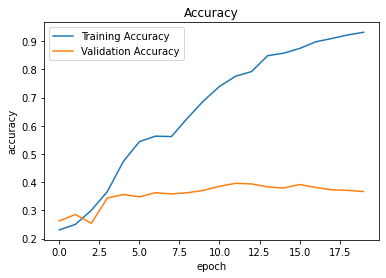

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

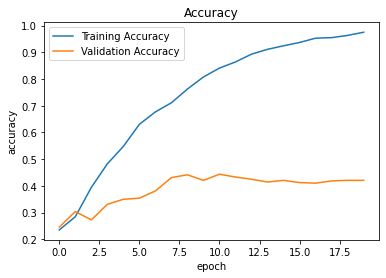

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

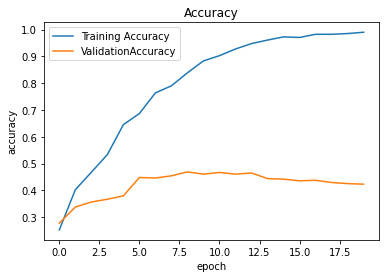

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history4.history['categorical_accuracy'])
plt.plot(history4.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m4acc.png', dpi=600)
plt.show()
files.download("m4acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history5.history['categorical_accuracy'])
plt.plot(history5.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m5acc.png', dpi=600)
plt.show()
files.download("m5acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history6.history['categorical_accuracy'])
plt.plot(history6.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m6acc.png', dpi=600)
plt.show()
files.download("m6acc.png") 

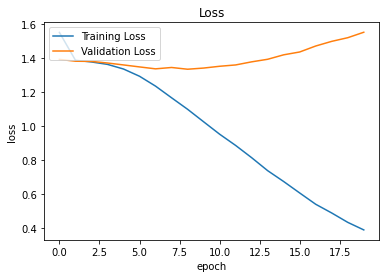

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

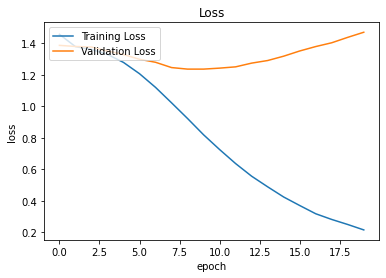

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

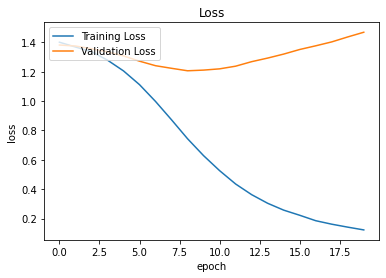

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m4loss.png', dpi=600)
plt.show()
files.download("m4loss.png") 


plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m5loss.png', dpi=600)
plt.show()
files.download("m5loss.png") 


plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m6loss.png', dpi=600)
plt.show()
files.download("m6loss.png") 

In [23]:
loss4, accuracy4 = model4.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss4, accuracy4))

loss5, accuracy5 = model5.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss5, accuracy5))

loss6, accuracy6 = model6.evaluate(X_test,y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss6, accuracy6))

Loss:	1.361939787864685
Accuracy:	0.4020833373069763
Loss:	1.4725289344787598
Accuracy:	0.4375
Loss:	1.4739168882369995
Accuracy:	0.45625001192092896


Third sessions

In [24]:
model7 = get_model(embedding1, dropout1, neuron1)
model8 = get_model(embedding1, dropout2, neuron1)
model9 = get_model(embedding1, dropout3, neuron1)

In [25]:
history7 = model7.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history8 = model8.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))
history9 = model9.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val))

Epoch 1/20
45/45 [==============================] - 1s 15ms/step - loss: 1.4258 - categorical_accuracy: 0.2465 - val_loss: 1.3843 - val_categorical_accuracy: 0.2771
Epoch 2/20
45/45 [==============================] - 1s 12ms/step - loss: 1.3794 - categorical_accuracy: 0.2951 - val_loss: 1.3863 - val_categorical_accuracy: 0.3271
Epoch 3/20
45/45 [==============================] - 1s 12ms/step - loss: 1.3691 - categorical_accuracy: 0.3549 - val_loss: 1.3761 - val_categorical_accuracy: 0.2521
Epoch 4/20
45/45 [==============================] - 1s 11ms/step - loss: 1.3452 - categorical_accuracy: 0.4451 - val_loss: 1.3691 - val_categorical_accuracy: 0.3438
Epoch 5/20
45/45 [==============================] - 1s 13ms/step - loss: 1.3116 - categorical_accuracy: 0.6285 - val_loss: 1.3505 - val_categorical_accuracy: 0.3688
Epoch 6/20
45/45 [==============================] - 1s 12ms/step - loss: 1.2572 - categorical_accuracy: 0.6472 - val_loss: 1.3194 - val_categorical_accuracy: 0.3896
Epoch 7/20

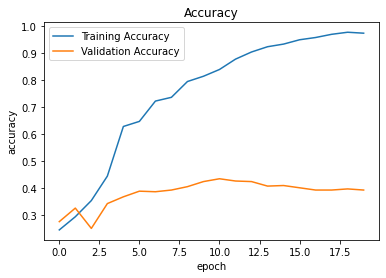

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

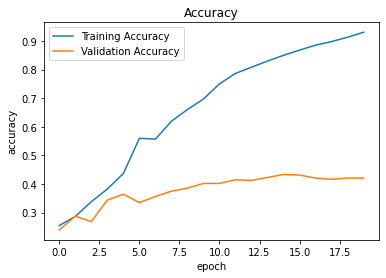

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

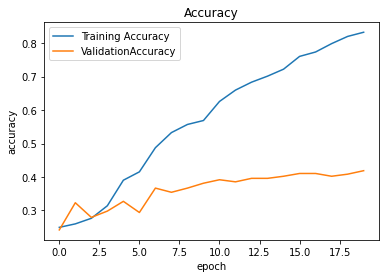

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history7.history['categorical_accuracy'])
plt.plot(history7.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m7acc.png', dpi=600)
plt.show()
files.download("m7acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history8.history['categorical_accuracy'])
plt.plot(history8.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('m8acc.png', dpi=600)
plt.show()
files.download("m8acc.png") 


#plt.plot('acc', marker='o')
plt.plot(history9.history['categorical_accuracy'])
plt.plot(history9.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'ValidationAccuracy'], loc='upper left')
# Display the plot
plt.savefig('m9acc.png', dpi=600)
plt.show()
files.download("m9acc.png") 

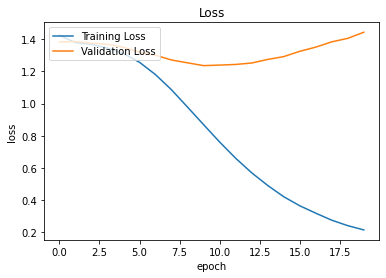

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

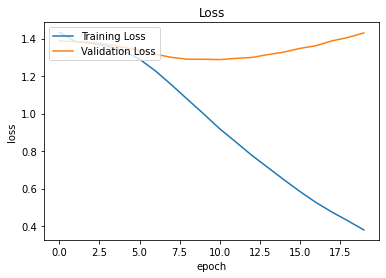

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

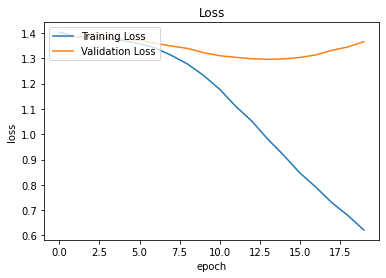

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m7loss.png', dpi=600)
plt.show()
files.download("m7loss.png") 


plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m8loss.png', dpi=600)
plt.show()
files.download("m8loss.png") 


plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('m9loss.png', dpi=600)
plt.show()
files.download("m9loss.png") 

In [28]:
loss7, accuracy7 = model7.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss7, accuracy7))

loss8, accuracy8 = model8.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss8, accuracy8))

loss9, accuracy9 = model9.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss9, accuracy9))

Loss:	1.3694356679916382
Accuracy:	0.4437499940395355
Loss:	1.3729246854782104
Accuracy:	0.42916667461395264
Loss:	1.2610530853271484
Accuracy:	0.44583332538604736


FINAL ANALYSIS

In [29]:
from google.colab import files
uploaded = files.upload()

Saving all_gospels.csv to all_gospels.csv


In [30]:
df = pd.read_csv("all_gospels.csv", delimiter=',', header=None,names=['id', 't','label'])

In [31]:
# Prepare predicted labels
df = df.iloc[1:]
Y = df.label
Y_series=pd.Series(Y,dtype='category')
Y = Y_series.cat.codes
y_prep = to_categorical(Y)
print(y_prep.shape)
print(Y_series)

(3779, 4)
1       0
2       0
3       0
4       0
5       0
       ..
3775    3
3776    3
3777    3
3778    3
3779    3
Name: label, Length: 3779, dtype: category
Categories (4, object): [0, 1, 2, 3]


In [32]:
# Create and fit tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.t)
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index
prep_data = tokenizer.texts_to_sequences(df.t)

In [33]:
prep_data = pad_sequences(prep_data, maxlen=200,padding="post")

In [34]:
print(len(prep_data))
print(len(Y))

3779
3779


In [35]:
# prepare train, test and validation data
X_train, X_test, y_train, y_test = train_test_split(prep_data, y_prep, test_size=0.2, random_state=42)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [37]:
model_final = get_model(embedding1,dropout3,neuron1)

In [38]:
class_weight = dict()
class_weight[0] = 1.1 #  Matthew 1071
class_weight[1] = 1.7 # Mark 678
class_weight[2] = 1 # Luke 1151
class_weight[3] = 1.3 # John 879

history_final = model_final.fit(X_train, y_train, epochs=20,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)

Epoch 1/20
71/71 [==============================] - 2s 23ms/step - loss: 1.7159 - categorical_accuracy: 0.2267 - val_loss: 1.3839 - val_categorical_accuracy: 0.3439
Epoch 2/20
71/71 [==============================] - 1s 13ms/step - loss: 1.6890 - categorical_accuracy: 0.2955 - val_loss: 1.3899 - val_categorical_accuracy: 0.3862
Epoch 3/20
71/71 [==============================] - 1s 13ms/step - loss: 1.6805 - categorical_accuracy: 0.3679 - val_loss: 1.3784 - val_categorical_accuracy: 0.2288
Epoch 4/20
71/71 [==============================] - 1s 13ms/step - loss: 1.6580 - categorical_accuracy: 0.3485 - val_loss: 1.3484 - val_categorical_accuracy: 0.4458
Epoch 5/20
71/71 [==============================] - 1s 14ms/step - loss: 1.6216 - categorical_accuracy: 0.4508 - val_loss: 1.3356 - val_categorical_accuracy: 0.3770
Epoch 6/20
71/71 [==============================] - 1s 14ms/step - loss: 1.5691 - categorical_accuracy: 0.4852 - val_loss: 1.2979 - val_categorical_accuracy: 0.4458
Epoch 7/20

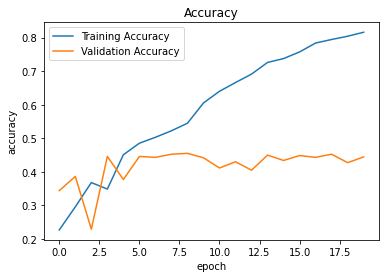

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# Insert lists of accuracy obtained on the validation set
#plt.plot('acc', marker='o')
plt.plot(history_final.history['categorical_accuracy'])
plt.plot(history_final.history['val_categorical_accuracy'])
# Add extra descriptions to plot
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
# Display the plot
plt.savefig('mfinalacc.png', dpi=600)
plt.show()
files.download("mfinalacc.png") 

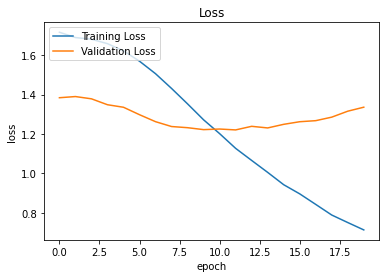

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
# Add extra descriptions to plot
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss','Validation Loss'], loc='upper left')
# Display the plot
plt.savefig('mfinalloss.png', dpi=600)
plt.show()
files.download("mfinalloss.png") 

In [42]:
loss_final, accuracy_final = model_final.evaluate(X_test, y_test, verbose=0)
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss_final, accuracy_final))

Loss:	1.4264612197875977
Accuracy:	0.4047619104385376


In [41]:
predicted = model_final.predict(X_test)
# see the predicted
print(predicted)   

[[0.34861726 0.2790967  0.33231378 0.03997235]
 [0.05452804 0.02922877 0.06776443 0.84847873]
 [0.71326494 0.0793231  0.15408957 0.0533223 ]
 ...
 [0.49768203 0.28148067 0.05671754 0.1641197 ]
 [0.32671395 0.22200625 0.43248156 0.0187982 ]
 [0.1246882  0.33823475 0.51879185 0.01828514]]


In [43]:
# changing the format of y_preds and y_tests to make the assessment of the network
idx = np.argmax(predicted, axis=-1)
y_preds= np.zeros(predicted.shape )
y_preds[np.arange(predicted.shape[0]), idx] = 1

print(y_preds)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [44]:
idx = np.argmax(y_test, axis=-1)
y_tests= np.zeros(y_test.shape )
y_tests[np.arange(y_test.shape[0]), idx] = 1

print(y_tests)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [45]:
# Create the performance report
print(classification_report(y_tests, y_preds))

              precision    recall  f1-score   support

           0       0.31      0.26      0.28       229
           1       0.29      0.39      0.33       140
           2       0.43      0.36      0.39       212
           3       0.59      0.65      0.62       175

   micro avg       0.40      0.40      0.40       756
   macro avg       0.40      0.42      0.41       756
weighted avg       0.40      0.40      0.40       756
 samples avg       0.40      0.40      0.40       756

